# Tools

NuclearTools has pint unit integration so values input with units will output results with like units.

To begin, simply input the module as seen below and pint can be input seperately to help keeps units consistent through analysis.

In [1]:
import NuclearTools.Tools as nt
import pint
import numpy as np
import pandas as pd
U = pint.UnitRegistry()

# Binding Energy

In [2]:
print(nt.BE_per_nucleon('U-235'))

7.390909556951814 megaelectron_volt


# Mass and Number Density

In [3]:
print('Atomic mass is    ', nt.atomic_mass("U-235"))

print('Standard_mass is  ', nt.standard_mass('U'))

print('Atomic number is  ', nt.atomic_number('U'))

print('Molecular mass is ', nt.molec_mass('UO2'))

print('Molecular mass is ', nt.molec_mass('Y3Al6BO3Si6O18OH4'))

print('Number density is ', nt.num_density('U-235', density=10.1))

Atomic mass is     235.0439299
Standard_mass is   238.02891
Atomic number is   92
Molecular mass is  270.02771
Molecular mass is  963.9493416
Number density is  2.5882392804255316e+22 / centimeter ** 3


# Q-Value

When finding the Q-value, reactants are input first in a list, followed by the list of products.  Neutrons are indicated by 'n', and protons are indicated by 'p'.

In [4]:
print(nt.Q_value(['n', 'U-235'], ['Kr-92', 'Ba-141', '3n']))

173.2898030655273 megaelectron_volt


# Elastic or Coherent Scattering Energy After Collision

First give the atom that is collided with, then the angle in degrees of rebound, and finally the initial energy where we can make use of pint to keep track of units.

In [5]:
print(nt.coh_scatter_energy('Cs-137', 25, 5 * U.MeV))

4.993165810676886 megaelectron_volt


# Cross Section Data and Plotting

This module can also pull in cross section data from https://www-nds.iaea.org/public/download-endf/.

The VIII version of ENDF (most current) is the one of choice in this package.  Each time a request is sent for a specific set of cross sections, they are pulled from this online repo and a temporary file is created with the data to ease the memory usage of a program. 

To pull in cross section data, first create an object around the reaction of interest, for example the (n,p) reaction of Fe-54.

The MF and MT parameters define what the cross section is versus and the type of reaction.  For example, MF=3 indicates cross section data versus energy and MT=103 indicates the (n,p) reaction.  For MT, input can be either a number or the reaction relating to that number such as '(n,p)' and for common reactions such as fission you can simply type MT = 'fission' or MT='(n,fission)'. 

In [6]:
iron_object = nt.cross_section('Fe-54', MF=3, MT='(n,p)')

cross_sections = iron_object.cross_sections

energies = iron_object.indep_var

Here we have created an iron object and no extra functions must be called to directly access the cross sections and the independent variables associated with each value.  Above is how the cross sections are accessed and how the independent variables are accessed as well, which is energy in our case since MF=3. 

We can also make a csv with two columns listing the independent variable data followed by the cross sections in the second column.  This file is saved to the current working directory. 

Another benefit is the ability to create a singular average by first defining an averaging function and then calling the single_average function.  Both of these abilities can be seen below.

In [7]:
iron_object.make_csv(filename="cross_data")

def averaging_function(energy):
    return .454*np.exp(-energy/.965)*np.sinh(np.sqrt(2.29*energy))

print(iron_object.single_average(func=averaging_function, func_units='MeV'))

0.08157602172188134


Lastly plotting is done by simply calling the plot function with no arguments.

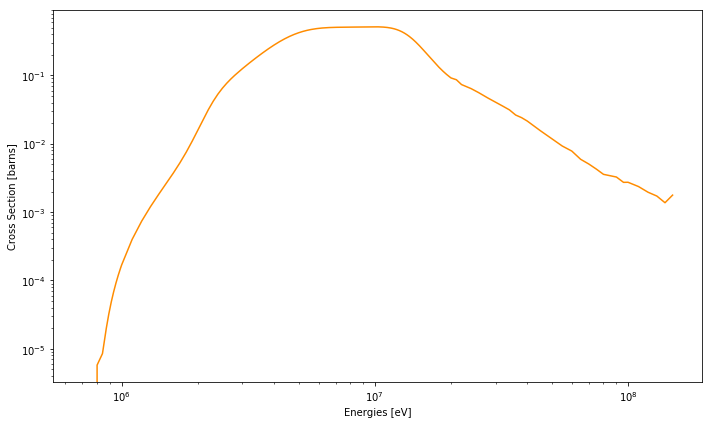

In [8]:
iron_object.plot()

# Disclaimer

For those unfamiliar with pint, the python units package, to obtain only the numerical value from any ouput simply add .magnitude to the end of any pint object.  For example ...

In [9]:
x = 5 * U.m
print(x)

print(x.magnitude)

print(x.units)

5 meter
5
meter


# Void Fractions

In [10]:
import NuclearTools.ThermalHydraulics as th
import pint
U = pint.UnitRegistry()

Void fractions can also be determined in the reactor by using the void_fractions class as seen below.  The intervals of the input indicate the volume fraction cutoffs for bubbly, bubbly slug, etc..

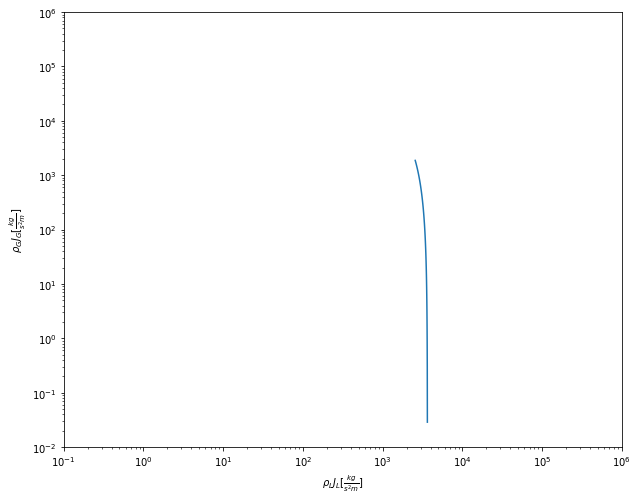

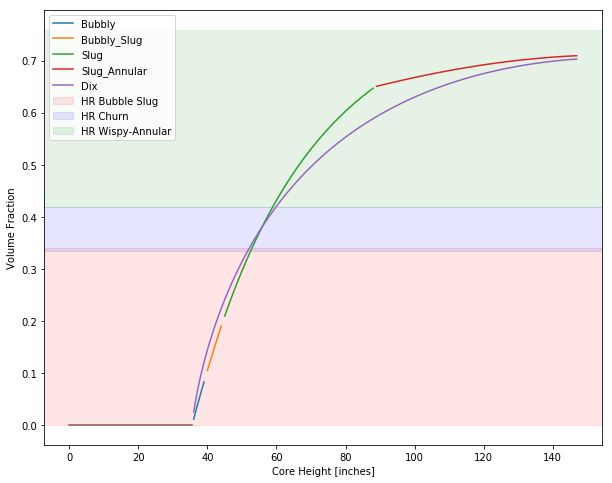

In [11]:
obj = th.void_fractions(heat_flux=144032*U.Btu/U.hour/U.foot**2,
             pressure=1040*U.psi,
             mass_flux=1.21*10**6 * U.lb/U.hour/U.foot**2,
             enthalpy=527.9*U.Btu/U.lb,
             height=148*U.inch,
             Fx=1.4,
             pitch=.64*U.inch,
             D_rod=.493*U.inch,
             U=U,
             intervals=(.1, .2, .65, .85, .9),
             life='MOC')
obj.plot_Hewitt_Roberts()
obj.plot()

# Thermal Hydraulics

The thermal hydraulics package is a powerful class that can calculate many different values from core temperatures to DNBR and CHF values.  To begin, several different types of data can be input.  Here is an example set of data below.  The program automatically calculates densities, viscosities, specific heats, etc. 

In [12]:
obj = th.reactor_thermals(
        power=3914*U.MW,
        height=150*U.inch,
        pitch=0.506*U.inch,
        T_inf=(556+458.67)*U.degR,
        Fq=2.34,
        Fx=1.5,
        D_clad=0.382*U.inch,
        D_pellet=.3255*U.inch,
        c_thick=0.025*U.inch,
        k_c=9.6*U.Btu/(U.hour*U.feet*U.rankine),
        n_rods=56876,
        hg=1000*U.Btu/(U.hour*U.feet**2*U.rankine),
        pressure=2250*U.psi,
        G=2.65*10**6*U.lb/(U.hour*U.feet**2),
        gamma=0.974,
        U=U,
        channel='hot',
        method='thom',
        life = 'MOC')

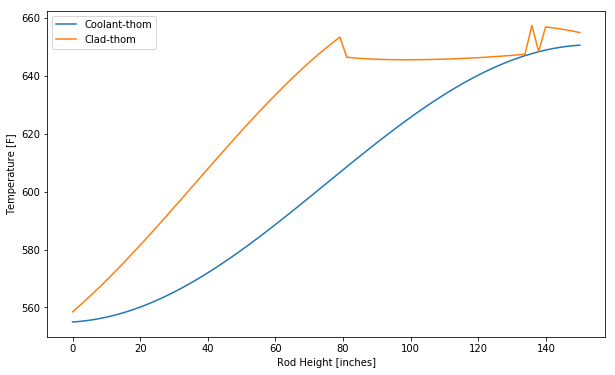

In [13]:
obj.plot(coolant=True, clad=True, units=U.degF, method=['thom'])

This plot is clearly not right for clad Temperature and this will usually come from a wrong guess in the mixed boiling region.  The automatic guess was too small so lets change our guess to a larger value (in degrees Rankine) and try again, this time with more methods of finding temperature in the mixed region.  The plotting for certain correlations can take significant amounts of time, especially for the chen correlation due to numerous transcendental solves per core height location.

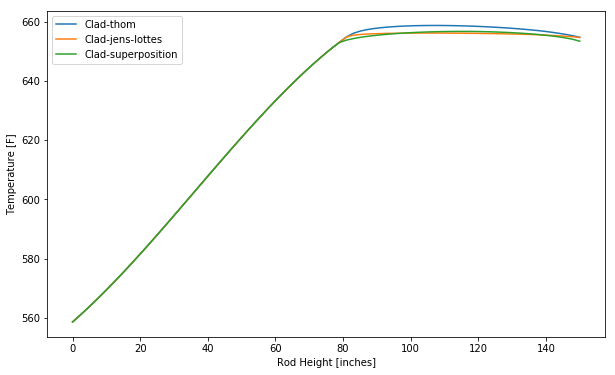

In [14]:
obj.T_mixed_guess = 1200
obj.plot(clad=True, units=U.degF, method=['thom', 'jens-lottes', 'superposition'])

Below we can also find several imporant values of the reactor core.

In [15]:
print('The saturation point of the clad is:', obj.T_clad_sat_location())
print('The incipient boiling point is:', obj.zn)
print('The fully developed nucleate boiling point is:', obj.zb)
print('The fluid sat. location is:', obj.T_coolant_sat_location())

The saturation point of the clad is: 78.35049069357649 inch
The incipient boiling point is: 80.60587110511418 inch
The fully developed nucleate boiling point is: 138.87410641218506 inch
The fluid sat. location is: 153.76114650391614 inch


We can also find the max fuel and clad temperatures as well as their respective axial location.  This max temperature will be calculated from the most recently called method to find clad temperature such as 'thom' or 'jens-lottes'.

In [16]:
print('The max clad temperature is ',(obj.max_T_clad()[0]).to(U.degF), 
      ' at ',obj.max_T_clad()[1])
print('The max fuel temperature is ',(obj.max_T_fuel()[0]).to(U.degF), 
      ' at ',obj.max_T_fuel()[1])

The max clad temperature is  656.895759567445 degF  at  115 inch
The max fuel temperature is  3516.1639478378183 degF  at  76 inch


In [17]:
print('The minimum DNB ratio is:', obj.MDNBR()[0], 'at', obj.MDNBR()[1])

The minimum DNB ratio is: 2.6123610920129607 at 104.0 inch


One useful way to quickly view all parameters, calculated and input for this 'reactor system' is to copy and execute the below code.  No need to change anything except for the object name which is 'obj' here.

In [18]:
table = {}
for inst in obj.__dict__.keys():
    table[inst] = obj.__dict__[inst]
df = pd.DataFrame(data=[table])
df.reindex(sorted(df.columns), axis=1)
print(df.transpose()[0:46])
print(df.transpose()[46:])

                                                               0
Ax                                 0.14142755840439075 inch ** 2
CPR                                                         None
D_clad                                                0.382 inch
D_pellet                                             0.3255 inch
De                                      0.47139047140264956 inch
Fq                                                          2.34
Fx                                                           1.5
G                             2650000.0 pound / foot ** 2 / hour
T_inf                                    1014.6700000000001 degR
T_mixed_guess                                               1200
T_sat                                    1112.4182789554984 degR
U              <pint.registry.UnitRegistry object at 0x000001...
c_thick                                               0.025 inch
cp                         1.4343283809769076 btu / degR / pound
cp_f                     

# Critical Heat Flux

One of the more important abilities of this code is its ability to find CHF values.  An example reactor input is given below (notice the change of input parameters from above).  We can also work backwards with this code and given a maximum CPR value, find the power of the reactor.

In [19]:
obj = th.reactor_thermals(
        height=148*U.inch,
        pitch=0.640*U.inch,
        T_inf=(532+458.67)*U.degR,
        Fq=2.22,
        Fx=1.4,
        D_clad=0.493*U.inch,
        n_rods=45384,
        pressure=1040*U.psi,
        G=1.21*10**6*U.lb/(U.hour*U.feet**2),
        gamma=0.943,
        U=U,
        channel='hot',
        method='thom',
        life = 'Bottom',
        CPR = 1.2)

In [20]:
print('The H0 value is:', obj.find_h0())
print('The critical q is:', obj.q_crit())
print('The max power is:', obj.max_Q().to(U.MW))

The H0 value is: 11.353748292363962 inch
The critical q is: 230743.88245629397 btu / foot ** 2 / hour
The max power is: 3538.809494336955 megawatt


In [21]:
print('The exit critical quality is:', obj.crit_quality(148))
print('The exit quality is:', obj.abs_quality(148))
print('The void fraction of the real channel is:', obj.alpha_dix(148, type='real'))
print('The void fraction of the critical channel is:', obj.alpha_dix(148, type='critical'))

The exit critical quality is: 0.3924066888948108
The exit quality is: 0.32093113995311573
The void fraction of the real channel is: 0.8221169998246636 dimensionless
The void fraction of the critical channel is: 0.8530856538027443 dimensionless


In [22]:
print('The minimum CHF ratio is:', obj.MCHF()[0], 'at', obj.MCHF()[1])

The minimum CHF ratio is: 1.5487737775234505 at 102 inch


The next steps of development will include coolant flow problems that involve needed pump powers, the flow rate given certain flow obstructions and core design, etc.

To see all functionality of the code, do not forget about the help() command.

Ex: help(th)

# Core Pressures and Mass Flux

We can additionally find higher level pressure drops across the system.  We will start with a specific steam generator with inputs given below.

In [23]:
import NuclearTools.MassFlux as mf
obj = mf.steam_generator(
    m = 36*10**6 * U.lb/U.hr,
    T_hl = (620 + 459.67) * U.degR,
    T_cl = (560 + 459.67) * U.degR,
    A_ht = 79800 * U.foot**2,
    n_tubes = 6633,
    D = .6875 * U.inch,
    wall_th = .04 * U.inch,
    L = 30.64 * U.foot,
    radius_max = 53.25 * U.inch,
    radius_min = 2.25 * U.inch,
    plate_th = 21.2 * U.inch,
    inlet_k = 1.5,
    exit_k = 1.0,
    eq_long = 55,
    eq_short = 90,
    U = U)

In [24]:
print('The total pressure loss is:', obj.total_dp)
print('')
print('The friction pressure loss is:', obj.dP_loss.to(U.psi))
print('The exit pressure loss is:', obj.dP_exit.to(U.psi))
print('The entrance pressure loss is:', obj.dP_plate.to(U.psi))

The total pressure loss is: 30.788242433526023 pound_force_per_square_inch

The friction pressure loss is: 24.632394868638567 pound_force_per_square_inch
The exit pressure loss is: 2.0459598885959243 pound_force_per_square_inch
The entrance pressure loss is: 4.109887676291534 pound_force_per_square_inch


Above we have all the pressure drops across the system.  Since this is a U-Tube SG, we can also see the difference in the short-leg and long-leg calculations. 

In [25]:
print('The average length velocity is:', obj.v_avg.to(U.foot/U.s))
print('The long-leg length velocity is:', obj.v_long.to(U.foot/U.s))
print('The short-leg length velocity is:', obj.v_short.to(U.foot/U.s))

The average length velocity is: 17.02281545360703 foot / second
The long-leg length velocity is: 17.14011441419696 foot / second
The short-leg length velocity is: 16.90789221304102 foot / second


Now we will switch over to the full core calculations

In [26]:
obj2 = mf.core_pressure(
    pitch = .496 * U.inch,
    D_clad = .374 * U.inch,
    n_rods = 55777,
    height = 144 * U.inch,
    pressure = 2250 * U.psi,
    n_grids = 8,
    k_grid = 0.5,
    core_height = 150 * U.inch,
    k_core_in = 1.5,
    k_core_out = 1.5,
    v_ID = 173 * U.inch,
    b_OD = 157.6 * U.inch,
    L_d = 21 * U.foot,
    k_d = 4.5,
    L_hl = 20 * U.foot,
    D_hl = 2.42 * U.foot,
    HL_LD = 10,
    k_hl_in = 1.5,
    k_hl_out = 1.0,
    k_sg_in = 1.5,
    k_sg_out = 1.0,
    SG_LD = 90,
    D_sg = .6875 * U.inch,
    SG_th = .04 * U.inch,
    n_tubes = 6633,
    A_total = 79800 * U.foot**2,
    L_cl = 40 * U.foot,
    D_cl = 2.29 * U.foot,
    k_cl_in = 1.5,
    k_cl_out = 1.0,
    CL_LD = 50,
    T_in = (560+459.67) * U.degR,
    T_out = (620+459.67) * U.degR,
    m = 144*10**6 * U.lb/U.hour,
    U = U,
    loops = 4)

In [27]:
print('The pressure change in the core:', obj2.P_core(obj2.m).to(U.psi))
print('The pressure change in the downcomer:', obj2.P_downcomer(obj2.m).to(U.psi))
print('The pressure change in the hot leg:', obj2.P_hot_leg(obj2.m).to(U.psi))
print('The pressure change in the steam generator:', obj2.P_sg(obj2.m).to(U.psi))
print('The pressure change in the cold leg:', obj2.P_cold_leg(obj2.m).to(U.psi))

The pressure change in the core: 20.409522168419116 pound_force_per_square_inch
The pressure change in the downcomer: 17.512949624355336 pound_force_per_square_inch
The pressure change in the hot leg: 31.30989607441203 pound_force_per_square_inch
The pressure change in the steam generator: 30.5177779653617 pound_force_per_square_inch
The pressure change in the cold leg: 46.966965200287845 pound_force_per_square_inch


In [28]:
print('The total pressure drop is:', obj2.P_total.to(U.psi))
print('The needed pump horsepower is:', obj2.work.to(U.hp))

The total pressure drop is: 149.31634426124694 pound_force_per_square_inch
The needed pump horsepower is: 11846.968391401917 horsepower
